# Package Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
#import matplotlib.pyplot as plt
#import matplotlib.patches as patches
#import seaborn as sns
#sns.set(font_scale=1.2, context="paper", style="ticks")
#sns.set_palette("viridis")

import mysql.connector as mariadb
from astropy.time import Time

#%matplotlib inline

#import plotly
#plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
os.environ.get("CONDA_PREFIX")

'/epyc/opt/anaconda'

In [3]:
os.nice(1)

1

In [4]:
import thor

## Run THOR

In [5]:
columnMapping = {        
        
        # Observation ID
        "obs_id" : "obs_id",
        
        # Exposure time
        "exp_mjd" : "exp_mjd",
        
        # Visit ID
        "visit_id" : "visit_id",
        
        # Field ID
        "field_id" : "field",
        
        # Field RA in degrees
        "field_RA_deg" : "fieldRA_deg",
        
        # Field Dec in degrees
        "field_Dec_deg" : "fieldDec_deg",
        
        # Night number
        "night": "nid",
        
        # RA in degrees
        "RA_deg" : "ra",
        
        # Dec in degrees
        "Dec_deg" : "decl",
        
        # Observer's x coordinate in AU
        "obs_x_au" : "HEclObsy_X_au",
        
        # Observer's y coordinate in AU
        "obs_y_au" : "HEclObsy_Y_au",
        
        # Observer's z coordinate in AU
        "obs_z_au" : "HEclObsy_Z_au",
        
        # Magnitude (UNUSED)
        "mag" : "magpsf",
        
        ### Truth Parameters
        
        # Object name
        "name" : "designation",
        
        # Observer-object distance in AU
        "Delta_au" : "Delta_au",
        
        # Sun-object distance in AU (heliocentric distance)
        "r_au" : "r_au",
        
        # Object's x coordinate in AU
        "obj_x_au" : "HEclObj_X_au",
        
        # Object's y coordinate in AU
        "obj_y_au" : "HEclObj_Y_au",
        
        # Object's z coordinate in AU
        "obj_z_au" : "HEclObj_Z_au",
        
        # Object's x velocity in AU per day
        "obj_dx/dt_au_p_day" : "HEclObj_dX/dt_au_p_day",
        
        # Object's y velocity in AU per day
        "obj_dy/dt_au_p_day" : "HEclObj_dY/dt_au_p_day",
        
        # Object's z velocity in AU per day
        "obj_dz/dt_au_p_day" : "HEclObj_dZ/dt_au_p_day",
        
        # Semi-major axis
        "a_au" : "a_au",
        
        # Inclination
        "i_deg" : "i_deg",
        
        # Eccentricity
        "e" : "e",
    }

In [6]:
simulated_ephemeris = pd.read_csv("../analysis/ztf/known_object_observations_nid_610_624.eph", sep=" ", index_col=False, low_memory=False)
orbits = pd.read_csv("../analysis/ztf/known_object_observations_nid_610_624.orb", sep=" ", index_col=False, low_memory=False)

observations = pd.read_csv("../analysis/ztf/known_object_observations_nid_610_624.txt", sep=" ", index_col=False, low_memory=False)
#observations = pd.read_csv("../analysis/ztf/observations_nid_610_624.txt", sep=" ", index_col=False, low_memory=False)

observations.sort_values(by="mjd", inplace=True)
#observations.drop(index=observations[observations["designation"].isna()].index, inplace=True)
observations.loc[observations["designation"].isna(), "designation"] = -1

In [7]:
allObjects_survey, summary_survey = thor.analyzeObservations(observations, columnMapping=columnMapping, minSamples=5, unknownIDs=[-1])

THOR: analyzeObservations
-------------------------
Analyzing observations...
Known object observations: 261369
Unknown object observations: 2731
False positive observations: 0
Percent known object observations (%): 98.966
Percent unknown object observations (%): 1.034
Percent false positive observations (%): 0.000
Unique known objects: 64313
Unique known objects with at least 5 detections: 22101

Total time in seconds: 0.40882420539855957
-------------------------



In [8]:
simulated_ephemeris["exp_mjd"] = simulated_ephemeris["mjd_utc"]

In [9]:
objs = observations[observations["nid"].isin([610, 611, 612])]["designation"].values
objs_findable = allObjects_survey[allObjects_survey["findable"] == 1]["designation"].values

In [10]:
ras = np.arange(0, 360 + 20, 20)
decs = np.arange(-90, 90 + 20, 20)

In [11]:
average_orbits_list = []

for ra_i, ra_f in zip(ras[:-1], ras[1:]):
    for dec_i, dec_f in zip(decs[:-1], decs[1:]):
        average_orbits_list.append(thor.findAverageOrbits(simulated_ephemeris[(simulated_ephemeris["designation"].isin(objs))
                                                                              & (simulated_ephemeris["designation"].isin(objs_findable))
                                                                              & (simulated_ephemeris["RA_deg"] >= ra_i) 
                                                                              & (simulated_ephemeris["RA_deg"] < ra_f)
                                                                              & (simulated_ephemeris["Dec_deg"] < dec_f)
                                                                              & (simulated_ephemeris["Dec_deg"] >= dec_i)],
                                                orbits[orbits["designation"].isin(objs)], 
                                                elementType="keplerian", 
                                                dValues=[0.0, 2.0, 2.2, 2.5, 3.0, 4.0, 10]))
                                                #columnMapping=columnMapping)
average_orbits = pd.concat(average_orbits_list)

THOR: findAverageObject
-------------------------
Finding average orbit in 6 distance bins...
No real objects found.
No real objects found.
No real objects found.
No real objects found.
No real objects found.
No real objects found.
Done.
-------------------------

THOR: findAverageObject
-------------------------
Finding average orbit in 6 distance bins...
No real objects found.
No real objects found.
No real objects found.
No real objects found.
No real objects found.
No real objects found.
Done.
-------------------------

THOR: findAverageObject
-------------------------
Finding average orbit in 6 distance bins...
No real objects found.
No real objects found.
No real objects found.
No real objects found.
No real objects found.
No real objects found.
Done.
-------------------------

THOR: findAverageObject
-------------------------
Finding average orbit in 6 distance bins...
No real objects found.
Done.
-------------------------

THOR: findAverageObject
-------------------------
Findi

In [12]:
average_orbits.sort_values(by=["r_au"], inplace=True)
average_orbits["orbit_id"] = np.arange(1, len(average_orbits) + 1)
average_orbits.reset_index(inplace=True, drop=True)

In [13]:
orbits["i_rad"] = np.radians(orbits["i_deg"])
orbits["ascNode_rad"] = np.radians(orbits["ascNode_deg"])
orbits["argPeri_rad"] = np.radians(orbits["argPeri_deg"])
orbits["meanAnom_rad"] = np.radians(orbits["meanAnom_deg"])

In [14]:
average_orbits = average_orbits.drop(index=average_orbits[average_orbits["designation"].isna()].index)

In [15]:
for orbit_id in average_orbits["orbit_id"].values:
    orbit = average_orbits[average_orbits["orbit_id"] == orbit_id]
    
    observations_orbit = observations[observations["designation"] == orbit["designation"].values[0]]
    new_epoch = observations_orbit["exp_mjd"].min()
    
    orbit_from_cat = orbits[orbits["designation"] == orbit["designation"].values[0]]
    current_epoch = orbit_from_cat["epoch_TT_mjd"]
    
    eph = thor.propagateTestParticle(orbit_from_cat[["a_au", "e", "i_rad", "ascNode_rad", "argPeri_rad", "meanAnom_rad"]].values[0], current_epoch, [new_epoch], observatoryCode="I41", mjdScale="TT", elementType="keplerian")
    
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "r_au"] = eph["r_au"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "RA_deg"] = eph["RA_deg"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "Dec_deg"] = eph["Dec_deg"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "exp_mjd"] = eph["mjd"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "HEclObj_dX/dt_au_p_day"] = eph["HEclObj_dX/dt_au_p_day"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "HEclObj_dY/dt_au_p_day"] = eph["HEclObj_dY/dt_au_p_day"].values[0]
    average_orbits.loc[average_orbits["orbit_id"] == orbit_id, "HEclObj_dZ/dt_au_p_day"] = eph["HEclObj_dZ/dt_au_p_day"].values[0]

In [16]:
average_orbits.head()

,orbit_id,r_au,HEclObj_dX/dt_au_p_day,HEclObj_dY/dt_au_p_day,HEclObj_dZ/dt_au_p_day,exp_mjd,RA_deg,Dec_deg,a_au,i_deg,e,designation
0,1,1.025066,0.007718,0.011664,-0.000857,58364.144005,268.121340,65.465395,0.776676,12.18718,0.381418,f3260
1,2,1.027711,0.005189,0.009883,-0.015598,58364.196829,272.643416,74.340634,1.422923,55.89077,0.289701,E4332
2,3,1.032093,0.007347,0.012865,-0.000785,58364.505093,65.749571,52.657946,0.837502,9.69923,0.436599,i6924
3,4,1.180452,0.014310,0.011141,-0.004187,58364.158495,248.517694,30.044428,1.910297,32.37981,0.382503,p4652
4,5,1.250445,0.006908,0.011531,-0.008758,58364.145845,269.315546,47.567524,1.370596,40.78599,0.269209,53789


In [17]:
average_orbits_in_observations = observations[observations["designation"].isin(average_orbits["designation"].values)].copy()
average_orbits_in_observations.drop_duplicates(subset=["designation"], keep="first", inplace=True)

In [18]:
average_orbits_in_observations

,ra,decl,field,nid,jd,exp_mjd,magpsf,sigmapsf,fid,ssnamenr,fieldRA_deg,fieldDec_deg,visit_id,mjd,HEclObsy_X_au,HEclObsy_Y_au,HEclObsy_Z_au,obs_id,designation,splitname
213507,268.326065,15.367513,587,610,2.458365e+06,58364.132882,18.8008,0.122414,2,138847,267.11592,18.95,7222,58364.132882,0.949965,-0.339551,0.000049,638417,D8847,138847
213510,265.790100,15.923739,587,610,2.458365e+06,58364.132882,18.5629,0.109997,2,107797,267.11592,18.95,7222,58364.132882,0.949965,-0.339551,0.000049,638420,A7797,107797
263394,268.172622,65.540742,825,610,2.458365e+06,58364.144005,18.3334,0.073235,2,413260,260.00000,62.15,20376,58364.144005,0.950028,-0.339372,0.000049,861069,f3260,413260
262395,269.322154,47.569260,764,610,2.458365e+06,58364.145845,19.0475,0.100558,2,53789,273.14738,47.75,18405,58364.145845,0.950039,-0.339342,0.000049,855603,53789,53789
249219,281.482034,34.428466,684,610,2.458365e+06,58364.146458,20.1496,0.156875,2,142781,282.56279,33.35,13586,58364.146458,0.950042,-0.339332,0.000048,807118,E2781,142781
213662,288.818438,17.956876,590,610,2.458365e+06,58364.147049,19.4557,0.121023,2,81583,288.92157,18.95,7521,58364.147049,0.950046,-0.339323,0.000048,639707,81583,81583
248955,248.524473,30.052451,680,610,2.458365e+06,58364.158495,20.3001,0.187441,2,514652,251.14964,33.35,12634,58364.158495,0.950111,-0.339137,0.000048,805654,p4652,514652
249052,278.063483,32.949830,683,610,2.458365e+06,58364.160868,19.5968,0.109671,2,83983,274.70950,33.35,13295,58364.160868,0.950125,-0.339099,0.000048,806681,83983,83983
123543,284.059769,5.475558,487,610,2.458365e+06,58364.166505,18.8735,0.067836,2,440938,281.19311,4.55,3120,58364.166505,0.950157,-0.339008,0.000048,341049,i0938,440938
123564,277.921444,2.895449,487,610,2.458365e+06,58364.166505,17.5394,0.058374,2,77645,281.19311,4.55,3120,58364.166505,0.950157,-0.339008,0.000048,341070,77645,77645


In [19]:
average_orbits = average_orbits.rename(columns={"RA_deg": columnMapping["RA_deg"], "Dec_deg": columnMapping["Dec_deg"]})

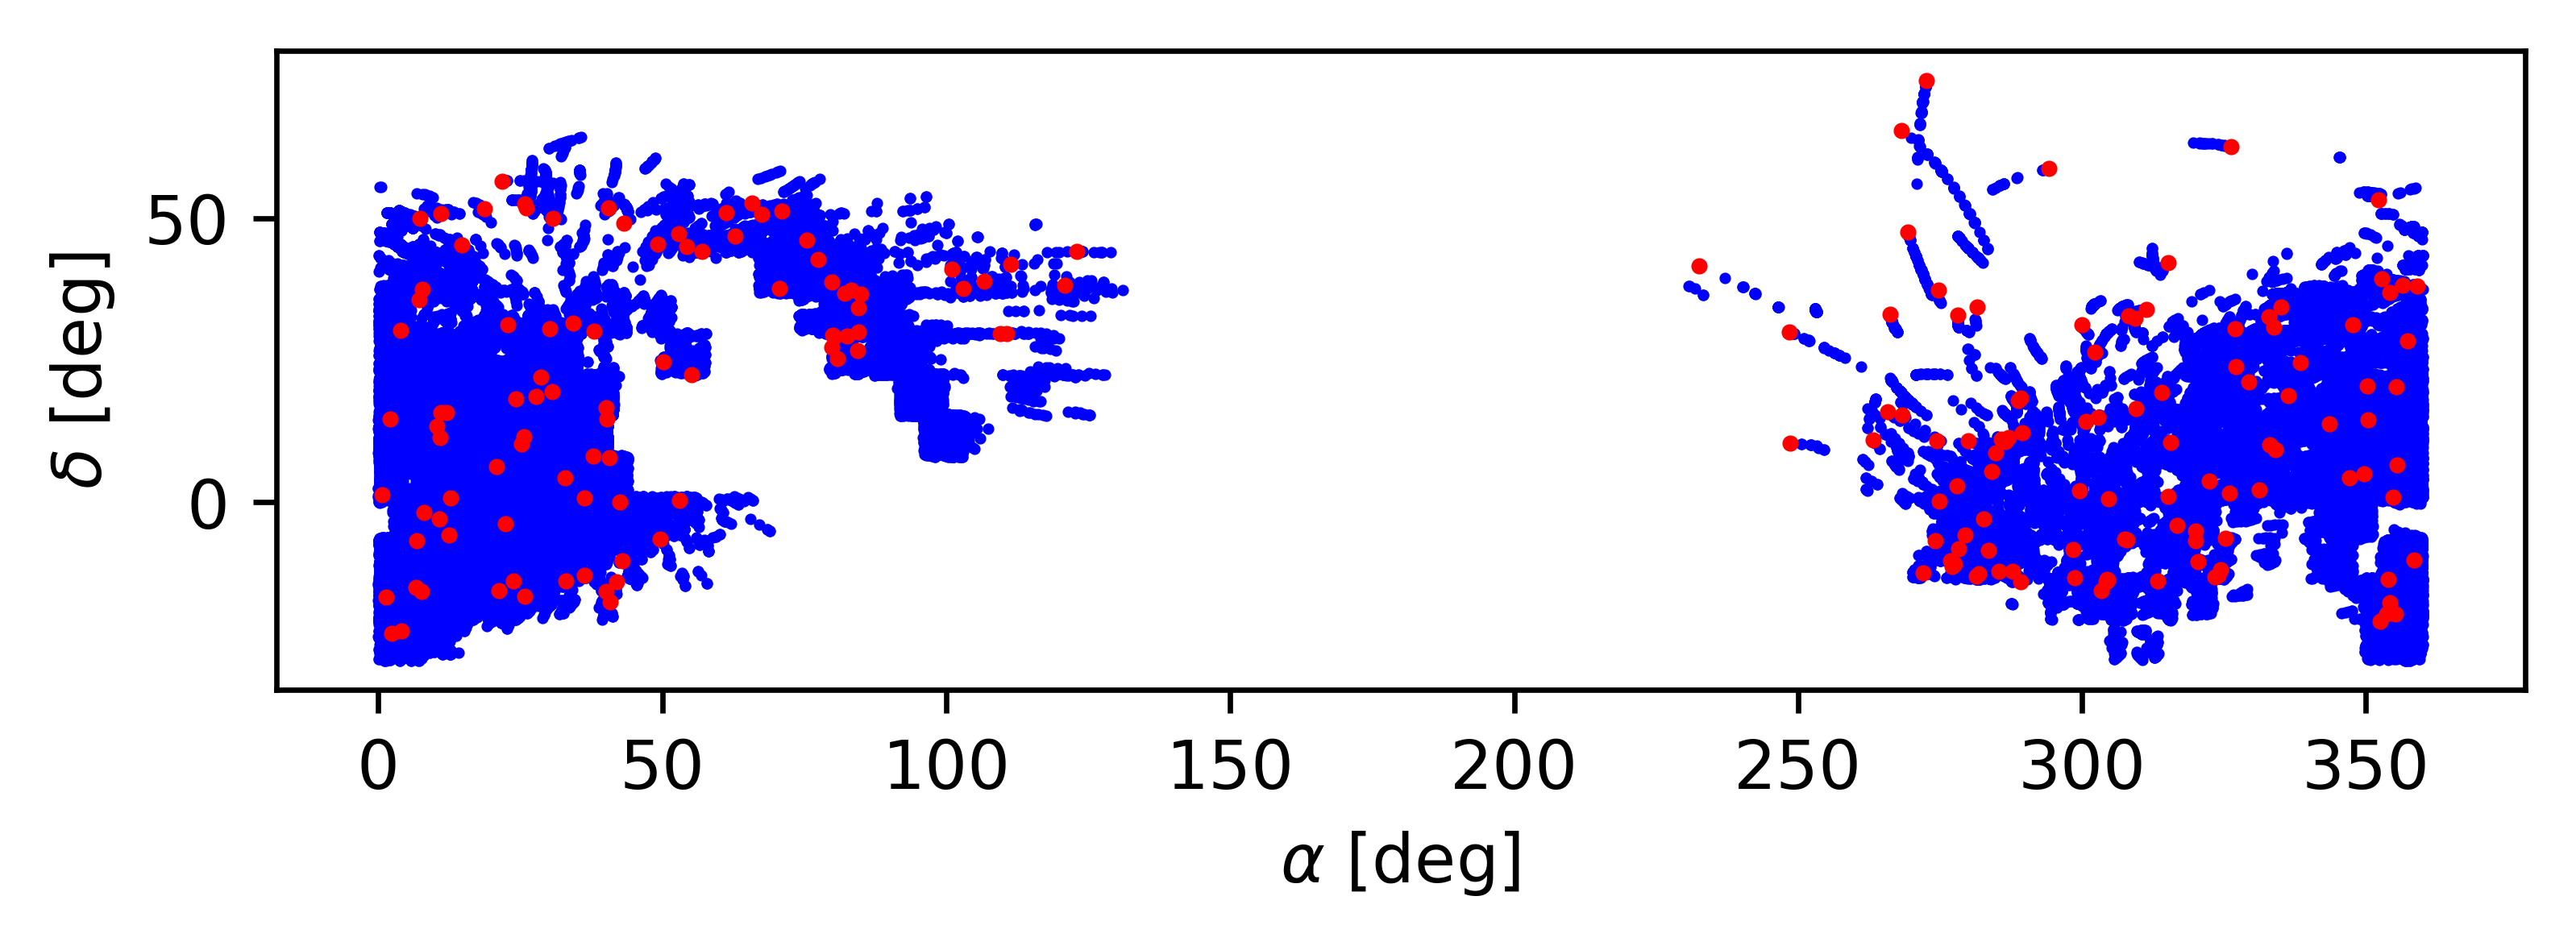

In [20]:
fig, ax = thor.plotting.plotObservations(observations[observations["designation"].isin(objs_findable)], columnMapping=columnMapping, usePlotly=False)
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values, c="r", s=2)

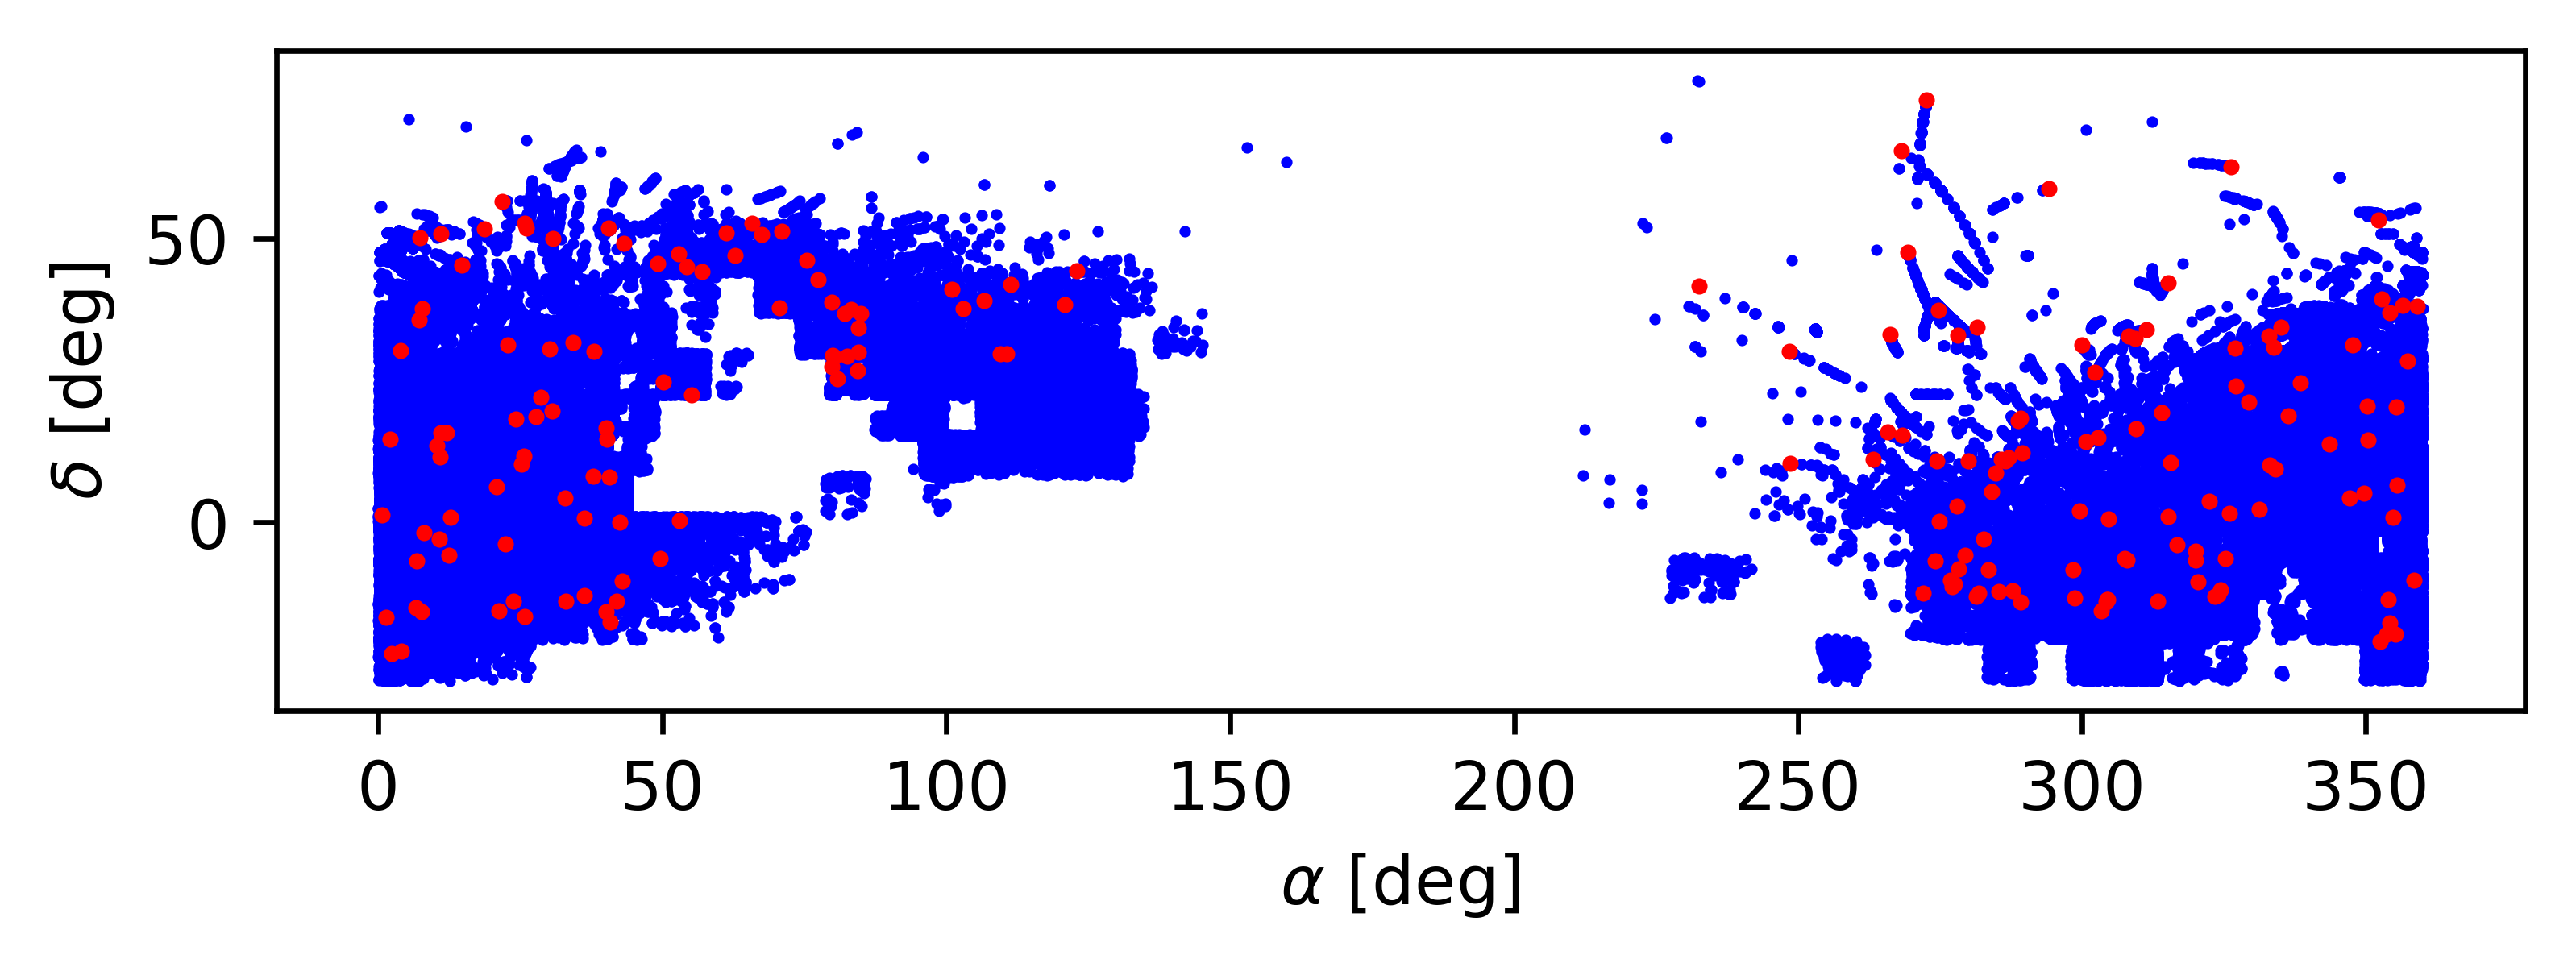

In [21]:
fig, ax = thor.plotting.plotObservations(observations, columnMapping=columnMapping, usePlotly=False)
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values, c="r", s=2)

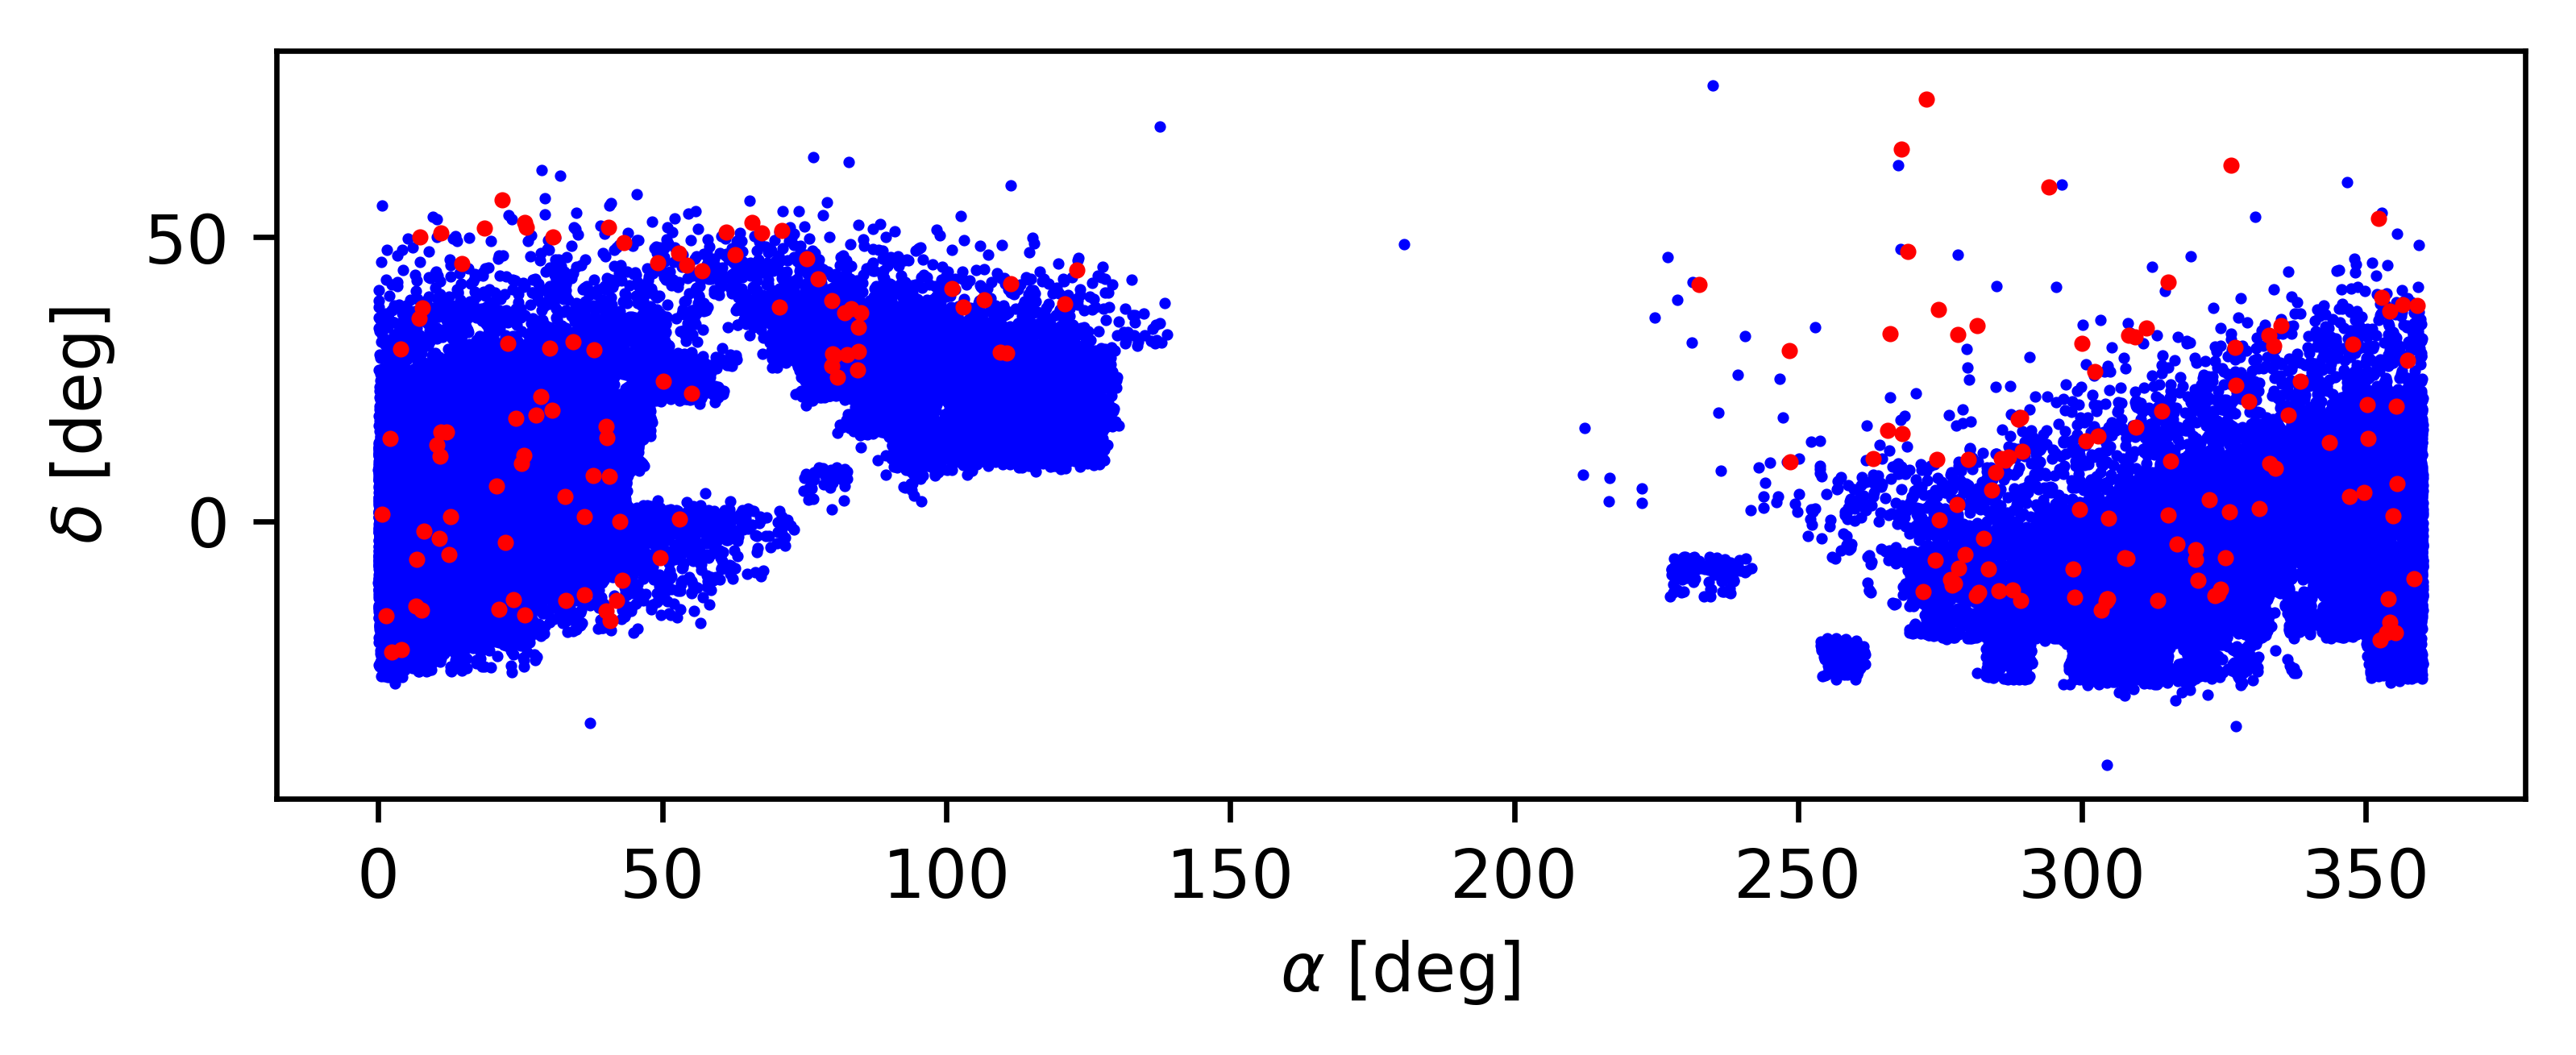

In [ ]:
fig, ax = thor.plotting.plotObservations(simulated_ephemeris, usePlotly=False)
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values,  c="r", s=2)

In [ ]:
! rm -rf ../analysis/ztf/run_2/

In [ ]:
observations = pd.merge(observations, simulated_ephemeris[["designation", "r_au"]], left_on="designation", right_on="designation")

In [ ]:
linked_detections = np.loadtxt("../analysis/ztf/run_1/linked_detections.txt")

In [ ]:
fig, ax = thor.plotting.plotObservations(observations[observations["designation"].isin(allObjects_survey[allObjects_survey["found"] == 1]["designation"].values) ], columnMapping=columnMapping, usePlotly=False)
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values, c="r", s=0.1)

In [ ]:
fig, ax = thor.plotting.plotObservations(observations[observations["designation"].isin(allObjects_survey[(allObjects_survey["found"] == 0) & (allObjects_survey["findable"] == 1)]["designation"].values) ], columnMapping=columnMapping, usePlotly=False)
ax.scatter(average_orbits[columnMapping["RA_deg"]].values, average_orbits[columnMapping["Dec_deg"]].values, c="r", s=0.1)

In [ ]:
allObjects_survey, summary_survey, summary_orbits = thor.runTHOR(observations, 
                                                                average_orbits, 
                                                                knownOrbits=orbits,
                                                                runDir="../analysis/ztf/run_2/", 
                                                                cellArea=500,
                                                                cellShape="circle",
                                                                threads=30,
                                                                vxBins=300,
                                                                vyBins=300,
                                                                eps=0.005,
                                                                minSamples=5,
                                                                unknownIDs=[-1],
                                                                columnMapping=columnMapping)

THOR: runTHOR
-------------------------
Running THOR with 199 orbits...

THOR: analyzeObservations
-------------------------
Analyzing observations...
Known object observations: 261369
Unknown object observations: 2731
False positive observations: 0
Percent known object observations (%): 98.966
Percent unknown object observations (%): 1.034
Percent false positive observations (%): 0.000
Unique known objects: 64313
Unique known objects with at least 5 detections: 22101

Total time in seconds: 0.45596885681152344
-------------------------

THOR: runTHOR
-------------------------
Running orbit 1...

THOR: analyzeProjections
-------------------------
Analyzing projections...
Known object observations: 159
Unknown object observations: 30
False positive observations: 0
Percent known object observations (%): 84.127
Percent unknown object observations (%): 15.873
Percent false positive observations (%): 0.000
Unique known objects: 5
Unique known objects with at least 5 detections: 4

Total tim

/epyc/projects/thor/envs/thor/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



THOR: clusterAndLink
-------------------------
Running velocity space clustering...
X velocity range: [-0.1, 0.1]
X velocity bins: 300
Y velocity range: [-0.1, 0.1]
Y velocity bins: 300
User defined x velocity values: False
User defined y velocity values: False
Velocity grid size: 90000
Max sample distance: 0.005
Minimum samples: 5
Using 30 threads...
Done. Completed in 13.092023134231567 seconds.

Restructuring clusters...
Done. Completed in 0.0747377872467041 seconds.

Found 12 clusters.
Total time in seconds: 13.168593168258667
-------------------------

THOR: analyzeClusters
-------------------------
Analyzing clusters...
Known object pure clusters: 12
Known object partial clusters: 0
Unknown object pure clusters: 0
Unknown object partial clusters: 0
False positive pure clusters: 0
False positive partial clusters: 0
Duplicate visit clusters: 0
False clusters: 0
Total clusters: 12
Cluster contamination (%): 0.000
Unique known objects linked: 1
Unique known objects missed: 60
Complet

../thor/analysis.py:562: RuntimeWarning:

divide by zero encountered in true_divide

../thor/analysis.py:563: RuntimeWarning:

divide by zero encountered in true_divide

../thor/analysis.py:564: RuntimeWarning:

divide by zero encountered in true_divide

/epyc/projects/thor/envs/thor/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning:

invalid value encountered in subtract

../thor/analysis.py:565: RuntimeWarning:

divide by zero encountered in true_divide



Known object observations: 8185
Unknown object observations: 140
False positive observations: 0
Percent known object observations (%): 98.318
Percent unknown object observations (%): 1.682
Percent false positive observations (%): 0.000
Unique known objects: 2449
Unique known objects with at least 5 detections: 585

Total time in seconds: 7.895163297653198
-------------------------

THOR: clusterAndLink
-------------------------
Running velocity space clustering...
X velocity range: [-0.1, 0.1]
X velocity bins: 300
Y velocity range: [-0.1, 0.1]
Y velocity bins: 300
User defined x velocity values: False
User defined y velocity values: False
Velocity grid size: 90000
Max sample distance: 0.005
Minimum samples: 5
Using 30 threads...
Done. Completed in 178.94133877754211 seconds.

Restructuring clusters...
Done. Completed in 4.890404939651489 seconds.

Found 26843 clusters.
Total time in seconds: 183.83341121673584
-------------------------

THOR: analyzeClusters
-------------------------
A

In [ ]:
average_orbits